<a href="https://colab.research.google.com/github/ozturkgizem/ImageImprovement-BGR-HSI-YCbCr-Hist.Eq./blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ozturkgizem/image-processing-MTM4552.git

In [ ]:
from PIL import Image

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
img = "./image-processing-MTM4552/hw/mandrill.ppm"
# imreadimg=cv2.imread("./image-processing-MTM4552/hw/mandrill.ppm")
rgbimg = cv2.cvtColor(cv2.imread(img,cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

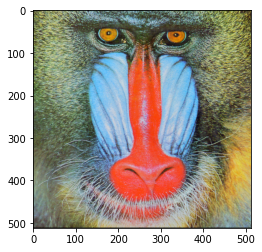

In [ ]:
plt.imshow(rgbimg)

HISTOGRAM EQUALIZATION FUNCTION

In [ ]:
def histogram_equalization(img, mode="rgb"):
    # Choose the color model that is most suitable for histogram equalization.
    if mode=="rgb":
        # We will equalize per color channel in RGB equalization
        ch = []
        for it in range(3):
            val, count = np.unique(img[:,:,it], return_counts=True)
            pdf = np.divide(count, sum(count))  # Probability Density Function pr(rk)
            cdf = (val.max()*np.cumsum(pdf)).astype(np.int32)  # Cummulative Density Function
            mp = np.arange(0, val.max()+1)
            mp[val] = cdf  # Map old pixel values to new pixel values
            ch.append(mp[img[:,:,it]])  # Update the pixel values
        heimage = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.int32)  # img must be a NumPy array
        heimage[:,:,0] = ch[0]  # Red channel
        heimage[:,:,1] = ch[1]  # Green channel
        heimage[:,:,2] = ch[2]  # Blue channel
        return heimage
    elif mode=="hsi":
        val, count = np.unique(img[:,:,-1], return_counts=True)  # Equalize on Intensity channel
        val = (val*255).astype(np.uint8)  # Convert val to 255
        pdf = np.divide(count, sum(count))  # Probability Density Function pr(rk)
        cdf = (val.max()*np.cumsum(pdf)).astype(np.int32)  # Cummulative Density Function
        mp = np.arange(0, val.max()+1)
        mp[val] = cdf  # Map old pixel values to new pixel values
        mul = np.multiply(img[:,:,-1], 255).astype(np.uint8)  # Temporarily convert to 255
        img[:,:,-1] = mp[mul]  # Update the pixel values
        img[:,:,-1] = img[:,:,-1]/255  # Convert back to 0-1
        r, g, b = hsi2rgb(img)  # Convert HSI color space to RGB color space
        heimage = np.zeros((img.shape[0], img.shape[1], 3))  # img must be a NumPy array
        heimage[:,:,0] = r  # Red channel
        heimage[:,:,1] = g  # Green channel
        heimage[:,:,2] = b  # Blue channel
        return heimage
    elif mode=="ycbcr":
        val, count = np.unique(img[:,:,-1], return_counts=True)  # Equalize on Cr channel
        val = (val*255).astype(np.uint8)  # Convert val to 255
        pdf = np.divide(count, sum(count))  # Probability Density Function pr(rk)
        cdf = (val.max()*np.cumsum(pdf)).astype(np.int32)  # Cummulative Density Function
        mp = np.arange(0, val.max()+1)
        mp[val] = cdf  # Map old pixel values to new pixel values
        mul = np.multiply(img[:,:,-1], 255).astype(np.uint8)  # Temporarily convert to 255
        img[:,:,-1] = mp[mul]  # Update the pixel values
        img[:,:,-1] = img[:,:,-1]/255  # Convert back to 0-1
        r, g, b = ycbcr2rgb(img)  # Convert HSI color space to RGB color space
        heimage = np.zeros((img.shape[0], img.shape[1], 3))  # img must be a NumPy array
        heimage[:,:,0] = r  # Red channel
        heimage[:,:,1] = g  # Green channel
        heimage[:,:,2] = b  # Blue channel
        return heimage
    else:
        raise Exception("No mode")

## **RGB TO HSI HISTOGRAM EQUALIZATION**

https://github.com/taerimyeon/RGB2HSI-HSI2RGB/blob/master/rgb2hsi.ipynb

RGB to HSI

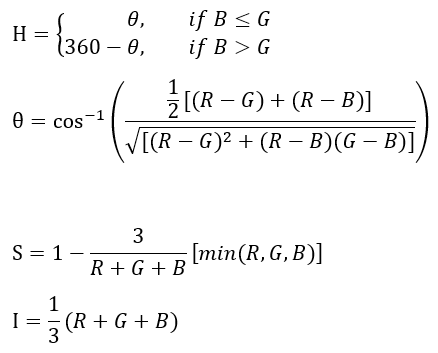

HSI to RGB

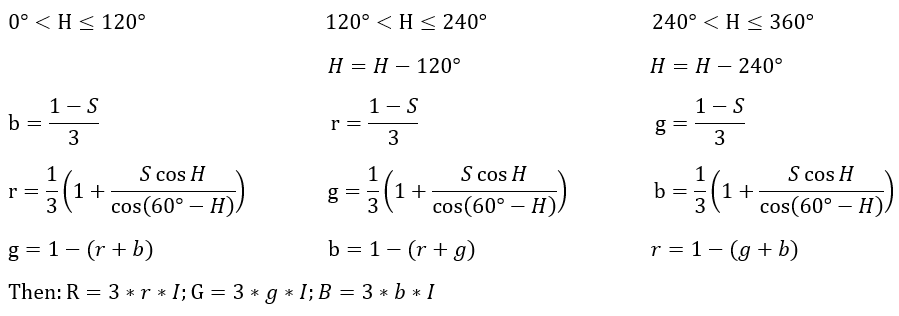

In [ ]:
def rgb2hsi(rgbimg):
    # Convert rgb images to hsi images
    # Hint: Normalize Hue value to [0,255] for demonstration purpose.
    rows, cols = rgbimg[:,:,0].shape  # We expect that for each channel image dims are same
    h = []    
    s = np.zeros((rows, cols), dtype=np.float32)  # Initialize s
    i = np.zeros((rows, cols), dtype=np.float32)  # Initialize i
    red = rgbimg[:,:,0]/255  # Normalize to 0-1
    green = rgbimg[:,:,1]/255
    blue = rgbimg[:,:,2]/255
    for r in range(rows):
        for c in range(cols):
            RG = red[r,c]-green[r,c]+0.001  # Red-Green, add a constant to prevent undefined value
            RB = red[r,c]-blue[r,c]+0.001  # Red-Blue
            GB = green[r,c]-blue[r,c]+0.001  # Green-Blue
            theta = np.arccos(np.clip(((0.5*(RG+RB))/(RG**2+RB*GB)**0.5), -1, 1))  # Still in radians
            theta = np.degrees(theta)  # Convert to degrees
            if blue[r,c] <= green[r,c]:
                h.append(theta)
            else:
                h.append(360 - theta)
    # Hue range will be automatically scaled to 0-255 by matplotlib for display
    # We will need to convert manually to range of 0-360 in hsi2rgb function
    h = np.array(h, dtype=np.int64).reshape(rows, cols)  # Convert Hue to NumPy array
    h = ((h - h.min()) * (1/(h.max() - h.min()) * 360))  # Scale h to 0-360
    minRGB = np.minimum(np.minimum(red, green), blue)
    s = 1-((3/(red+green+blue+0.001))*minRGB)  # Add 0.001 to prevent divide by zero
    i = (red+green+blue)/3  # Intensity: 0-1
    return h, s, i

def hsi2rgb(hsiimg):
    # Convert hsi images to rgb images
    rows, cols = hsiimg[:,:,0].shape  # We expect that for each channel image dims are same
    h = hsiimg[:,:,0]  # 0-360
    h = ((h - h.min()) * (1/(h.max() - h.min()) * 360))  # Scale h to 0-360
    s = hsiimg[:,:,1]  # 0-1
    i = hsiimg[:,:,2]  # 0-1
    rd, gr, bl = [], [], []  # Initialize r, g, and b as empty array
    for r in range(rows):
        for c in range(cols):
            if (h[r,c] >= 0 and h[r,c] <= 120):
                red = (1+((s[r, c]*np.cos(np.radians(h[r, c])))/np.cos(np.radians(60-h[r, c]))))/3
                blue = (1-s[r, c])/3
                rd.append(red)
                gr.append(1-(red+blue))
                bl.append(blue)
            elif (h[r,c] > 120 and h[r,c] <= 240):
                h[r, c] = h[r, c]-120
                red = (1-s[r, c])/3
                green = (1+((s[r, c]*np.cos(np.radians(h[r, c])))/np.cos(np.radians(60-h[r, c]))))/3
                rd.append(red)
                gr.append(green)
                bl.append(1-(red+green))
            elif (h[r,c] > 240 and h[r,c] <= 360):
                h[r, c] = h[r, c]-240
                green = (1-s[r, c])/3
                blue = (1+((s[r, c]*np.cos(np.radians(h[r, c])))/np.cos(np.radians(60-h[r, c]))))/3
                rd.append(1-(green+blue))
                gr.append(green)
                bl.append(blue)
    rd = np.multiply(rd, 3*i.flatten()).reshape(rows, cols)  # R = r*3*i, where r = rd in previous row
    gr = np.multiply(gr, 3*i.flatten()).reshape(rows, cols)
    bl = np.multiply(bl, 3*i.flatten()).reshape(rows, cols)
    return rd, gr, bl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'RGB to HSI and HSI to RGB Image Conversion')

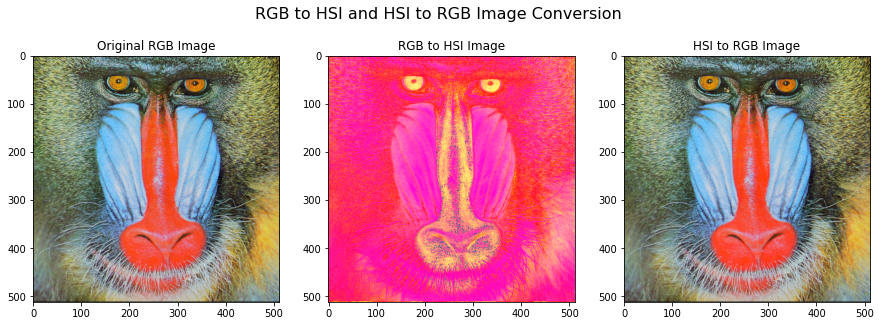

In [ ]:
h, s, i = rgb2hsi(rgbimg)
# Construct hsi images
HSIimg = np.zeros((rgbimg.shape[0], rgbimg.shape[1], 3))
HSIimg[:,:,0] = h
HSIimg[:,:,1] = s
HSIimg[:,:,2] = i

r, g, b = hsi2rgb(HSIimg)
# Construct rgb images
RGBimg = np.zeros((rgbimg.shape[0], rgbimg.shape[1], 3))
RGBimg[:,:,0] = r
RGBimg[:,:,1] = g
RGBimg[:,:,2] = b

# Display original RGB image, RGB2HSI, and HSI2RGB images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(rgbimg)
plt.title("Original RGB Image")
plt.subplot(1,3,2)
plt.imshow(HSIimg)
plt.title("RGB to HSI Image")
plt.subplot(1,3,3)
plt.imshow(RGBimg)
plt.title("HSI to RGB Image")
plt.suptitle("RGB to HSI and HSI to RGB Image Conversion", fontsize=16)

HISTOGRAM EQUALIZATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'HSI Image Histogram Eq (converted to RGB)')

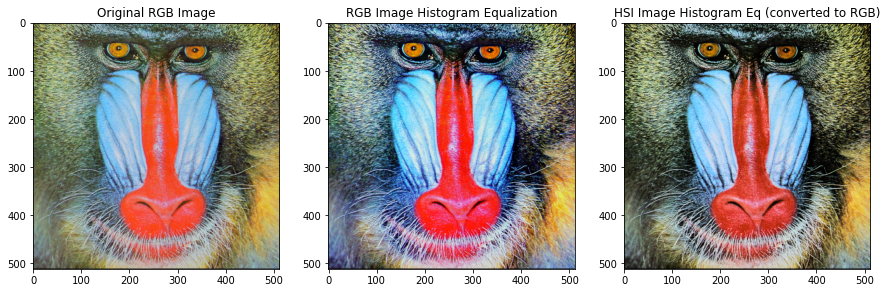

In [ ]:
heimgrgb = histogram_equalization(rgbimg, "rgb")  # Choose the color model you want to use as input here (rgbimg or hsiimg)
heimghsi = histogram_equalization(HSIimg, "hsi")

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(rgbimg)
plt.title("Original RGB Image")
plt.subplot(1,3,2)
plt.imshow(heimgrgb)
plt.title("RGB Image Histogram Equalization")
plt.subplot(1,3,3)
plt.imshow(heimghsi)
plt.title("HSI Image Histogram Eq (converted to RGB)")

In [ ]:
#min-max normalization and save (error: values aren't in range og 0-1)
#without this code block it does not allow me to save the image
min_val = np.min(heimgrgb)
max_val = np.max(heimgrgb)
img_data_clamped1 = (heimgrgb - min_val) / (max_val - min_val)
plt.imsave("./rbg2hsi1rgb.ppm", img_data_clamped1)

min_val = np.min(heimghsi)
max_val = np.max(heimghsi)
img_data_clamped2 = (heimghsi - min_val) / (max_val - min_val)
plt.imsave("./rbg2hsi2hsi.ppm", img_data_clamped2)

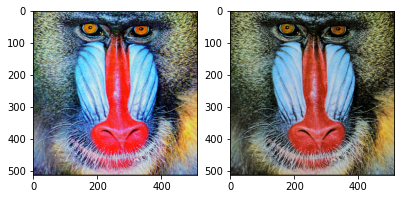

In [ ]:
#control
rgbimg1 = cv2.cvtColor(cv2.imread("./rbg2hsi1rgb.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
rgbimg2 = cv2.cvtColor(cv2.imread("./rbg2hsi2hsi.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(rgbimg1)
plt.subplot(1,3,2)
plt.imshow(rgbimg2)

## **RGB TO YCbCr HISTOGRAM EQUALIZATION**

https://github.com/dvrbic/RGB-to-YCBCR/blob/master/3.1.3_3.1.4/rgb_to_ycbcr_andback.py does not work properly but I built my algorith based on this

http://what-when-how.com/introduction-to-video-and-image-processing/conversion-between-rgb-and-yuvycbcr-introduction-to-video-and-image-processing/

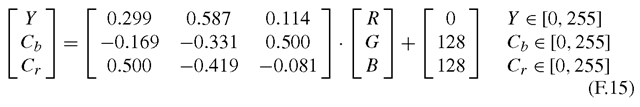

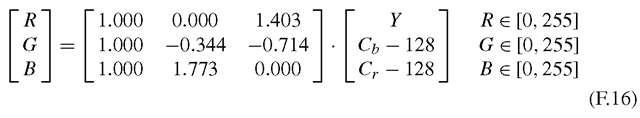

Here: 128 is added/subtracted in order to bring the values into the range [0, 255] and  when I put +/-128 it makes the result so green. :(

-> https://www.chegg.com/homework-help/questions-and-answers/matlab-convert-jpg-images-ycbcr-without-using-built-rgb2ycbr-function-q44689095
In this question, they put only 0.5 in formula instead of 128. So I replace it with 0.5 and get a similar result w ex. images that i see in papers about this subject.

In [ ]:
def rgb2ycbcr(image):
    img = (image.astype(float)/255)
    Y = np.empty([img.shape[0],img.shape[1]], dtype = float)
    Cb = np.empty([img.shape[0],img.shape[1]], dtype = float)
    Cr = np.empty([img.shape[0],img.shape[1]], dtype = float)
    red = image[:,:,0]/255  # Normalize to 0-1
    green = image[:,:,1]/255
    blue = image[:,:,2]/255
    Y = (0.299)*red + (0.587)*green + (0.114)*blue 
    Cb = (-0.1687)*red + (-0.3313)*green + (0.5)*blue + 0.5
    Cr = (0.5)*red + (-0.4187)*green + (-0.0813)*blue + 0.5
    #img_new = cv2.merge((Cr*255, Cb*255, Y*255))
    return Y, Cb, Cr

def ycbcr2rgb(image):
    img = (image.astype(float)/255)
    y = image[:,:,0]  # 0-360
    # y = ((y - y.min()) * (1/(y.max() - y.min()) * 360))  # Scale h to 0-360
    cb = image[:,:,1]  # 0-1
    cr = image[:,:,2]  # 0-1
    r = np.empty([img.shape[0],img.shape[1]], dtype = float)
    g = np.empty([img.shape[0],img.shape[1]], dtype = float)
    b = np.empty([img.shape[0],img.shape[1]], dtype = float)
    r = (1)*y + (0)*(cb-0.5) + (1.403)*(cr-0.5)
    g = (1)*y + (-0.34414)*(cb-0.5) + (-0.71414)*(cr-0.5)
    b = (1)*y + (1.772)*(cb-0.5) + (0)*(cr-0.5)
    #img_new = cv2.merge((b*255, g*255, r*255))
    return r, g, b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'RGB to YCbCr and YCbCr to RGB Image Conversion')

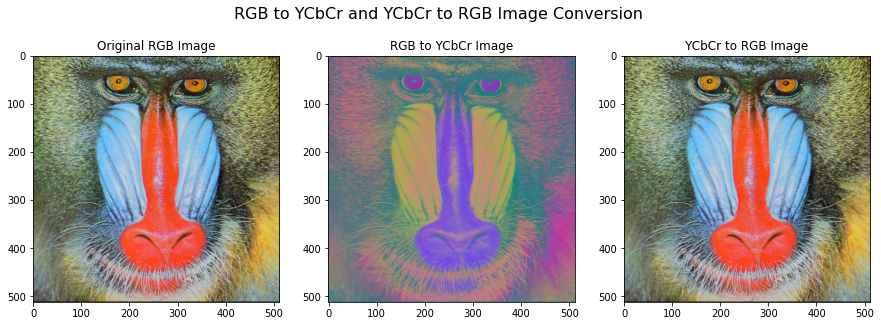

In [ ]:
y, cb, cr = rgb2ycbcr(rgbimg)
# Construct hsi images
YCbCrimg = np.zeros((rgbimg.shape[0], rgbimg.shape[1], 3))
YCbCrimg[...,0] = y
YCbCrimg[...,1] = cb
YCbCrimg[...,2] = cr

r1, g1, b1 = ycbcr2rgb(YCbCrimg)
# Construct rgb images
RGBimg2 = np.zeros((rgbimg.shape[0], rgbimg.shape[1], 3))
RGBimg2[:,:,0] = r1
RGBimg2[:,:,1] = g1
RGBimg2[:,:,2] = b1

# Display original RGB image, RGB2YCbCr, and YCbCr2RGB images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(rgbimg)
plt.title("Original RGB Image")
plt.subplot(1,3,2)
plt.imshow(YCbCrimg)
plt.title("RGB to YCbCr Image")
plt.subplot(1,3,3)
plt.imshow(RGBimg2)
plt.title("YCbCr to RGB Image")
plt.suptitle("RGB to YCbCr and YCbCr to RGB Image Conversion", fontsize=16)

HISTOGRAM EQUALIZATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'YCbCr Image Histogram Eq (converted to RGB)')

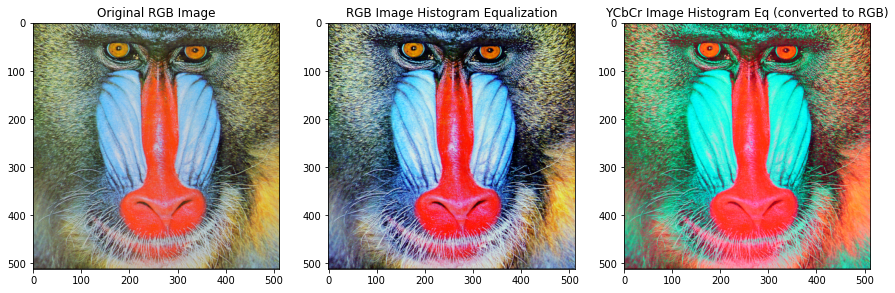

In [ ]:
heimgrgb2 = histogram_equalization(rgbimg, "rgb")  # Choose the color model you want to use as input here (rgbimg or hsiimg)
heimgycbcr = histogram_equalization(YCbCrimg, "ycbcr")

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(rgbimg)
plt.title("Original RGB Image")
plt.subplot(1,3,2)
plt.imshow(heimgrgb2)
plt.title("RGB Image Histogram Equalization")
plt.subplot(1,3,3)
plt.imshow(heimgycbcr)
plt.title("YCbCr Image Histogram Eq (converted to RGB)")

In [ ]:
#min-max normalization and save (error: values aren't in range og 0-1)
min_val = np.min(heimgrgb2)
max_val = np.max(heimgrgb2)
img_data_clamped3 = (heimgrgb2 - min_val) / (max_val - min_val)
plt.imsave("./rbg2ycbcr1rgb.ppm", img_data_clamped3)

min_val = np.min(heimgycbcr)
max_val = np.max(heimgycbcr)
img_data_clamped4 = (heimgycbcr - min_val) / (max_val - min_val)
plt.imsave("./rbg2ycbcr2ycbcr.ppm", img_data_clamped4)

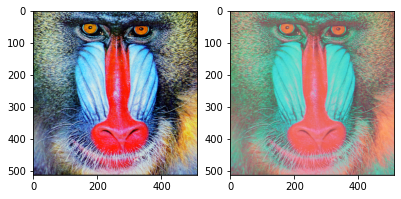

In [ ]:
#control
rgbimg3 = cv2.cvtColor(cv2.imread("./rbg2ycbcr1rgb.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
rgbimg4 = cv2.cvtColor(cv2.imread("./rbg2ycbcr2ycbcr.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(rgbimg3)
plt.subplot(1,3,2)
plt.imshow(rgbimg4)

HISTOGRAM EQUALIZED RGB2HSI and RGB2YCBCR -> THAN APPLIED HSI2RGB n YCBCR2RGB

Text(0.5, 1.0, 'YCbCr Image Histogram Eq (converted to RGB)')

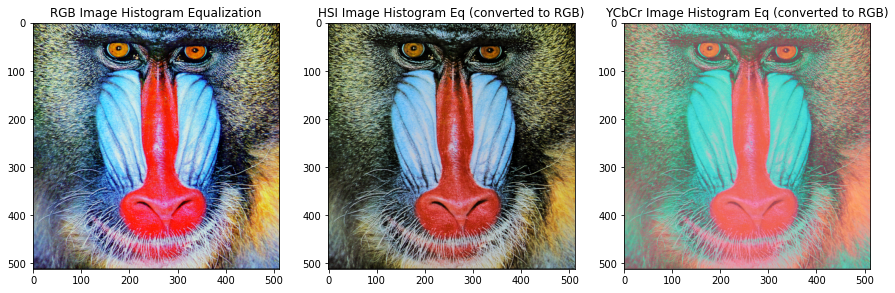

In [ ]:
rgbimg5 = cv2.cvtColor(cv2.imread("./rbg2hsi2hsi.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
rgbimg6 = cv2.cvtColor(cv2.imread("./rbg2ycbcr2ycbcr.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
rgbimg3 = cv2.cvtColor(cv2.imread("./rbg2ycbcr1rgb.ppm",cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 5))
plt.title("Saved Histogram Equalization Images")
plt.subplot(1,3,1)
plt.imshow(rgbimg3)
plt.title("RGB Image Histogram Equalization")
plt.subplot(1,3,2)
plt.imshow(rgbimg5)
plt.title("HSI Image Histogram Eq (converted to RGB)")
plt.subplot(1,3,3)
plt.imshow(rgbimg6)
plt.title("YCbCr Image Histogram Eq (converted to RGB)")

# SNR/PSNR

**PSNR**

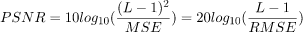

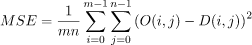

https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/

In [ ]:
from math import log10, sqrt
from skimage import io 
  
def PSNR(original, compressed):
    original = original.astype(np.float64) / 255.
    compressed = compressed.astype(np.float64) / 255.
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

original = cv2.cvtColor(io.imread(img), cv2.COLOR_RGB2BGR)

# original hist eq
RGBHEQ = cv2.cvtColor(io.imread("./rbg2ycbcr1rgb.ppm"), cv2.COLOR_RGB2BGR) 
value = PSNR(original, RGBHEQ)
print(f"PSNR value for RGB-Hist. Eq. Image is {value} dB")

# hsi hist eq
HSIHEQ = cv2.cvtColor(io.imread("./rbg2hsi2hsi.ppm"), cv2.COLOR_RGB2BGR) 
value1 = PSNR(original, HSIHEQ)
print(f"PSNR value for HSI-Hist. Eq. Image is {value1} dB")

# ycbcr hist eq
YCBCRHEQ = cv2.cvtColor(io.imread("./rbg2ycbcr2ycbcr.ppm"), cv2.COLOR_RGB2BGR)
value2 = PSNR(original, YCBCRHEQ)
print(f"PSNR value for YCbCr-Hist. Eq. Image is {value2} dB")

print("\n")

#hsi img
value3 = PSNR(original, HSIimg)
print(f"PSNR value for HSI Image is {value3} dB")

# ycbcr img
value4 = PSNR(original, YCbCrimg)
print(f"PSNR value for YCbCr Image is {value4} dB")


PSNR value for RGB-Hist. Eq. Image is 69.02827543912987 dB
PSNR value for HSI-Hist. Eq. Image is 66.28412508726733 dB
PSNR value for YCbCr-Hist. Eq. Image is 65.44789255053412 dB


PSNR value for HSI Image is 54.29710555307924 dB
PSNR value for YCbCr Image is 53.47307756462258 dB




---


PSNR: Typical values for the PSNR in lossy image and video compression are 
between 30 and 50 dB, provided the bit depth is 8 bits.

When I not use the line np.float in code it gives:
*   PSNR value for RGB-Hist. Eq. Image is 28.30200325602376 dB
*   PSNR value for HSI-Hist. Eq. Image is 28.316506440587347 dB
*   PSNR value for YCbCr-Hist. Eq. Image is 27.881252693385086 dB

In some resources they say it is a good metric to.


---




**SNR**

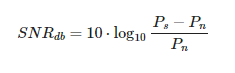

in signals *10 in images *20

https://github.com/sujit-deokar/Signal-to-Noise-ratio-SNR-/blob/master/snr_image.py

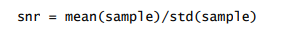

https://web.njit.edu/~gary/322/assets/Lab_2.pdf

In [ ]:
def SNRdifference(original, imagex):
  image = original ## input orignal image
  mean_image = np.mean(image)
  noisy_image = imagex ## input noisy image
  noise = noisy_image - image
  mean_noise = np.mean(noise)
  noise_diff = noise - mean_noise
  var_noise = np.sum(np.mean(noise_diff**2)) ## variance of noise
  if var_noise == 0:
      snr = 100 ## clean image
  else:
      snr = (np.log10(mean_image/var_noise))*10 ## SNR of the image
      
  return snr

def SNR(original):
  image = original ## input orignal image
  snr = np.mean(image)/np.std(image)    
  return snr

original = cv2.cvtColor(io.imread(img), cv2.COLOR_RGB2BGR)
valuex = SNR(original)
print(f"SNR value for Original Image is {valuex} dB")

#hsi img
value3 = SNR(HSIimg)
print(f"SNR value for HSI Image is {value3} dB")
value31 = SNRdifference(original, HSIimg)
print(f"SNR difference value for HSI Image is {value31} dB")

# ycbcr img
value4 = SNR(YCbCrimg)
print(f"SNR value for YCbCr Image is {value4} dB")
value41 = SNRdifference(original, YCbCrimg)
print(f"SNR difference value for YCbCr Image is {value41} dB")

print("\n")

# original hist eq
RGBHEQ = cv2.cvtColor(io.imread("./rbg2ycbcr1rgb.ppm"), cv2.COLOR_RGB2BGR) 
value = SNR(RGBHEQ)
print(f"SNR value for RGB-Hist. Eq. Image is {value} dB")
value111 = SNRdifference(original, RGBHEQ)
print(f"SNR value for HSI Image is {value111} dB")

# hsi hist eq
HSIHEQ = cv2.cvtColor(io.imread("./rbg2hsi2hsi.ppm"), cv2.COLOR_RGB2BGR) 
value1 = SNR(HSIHEQ)
print(f"SNR value for HSI-Hist. Eq. Image is {value1} dB")
value11 = SNRdifference(original, HSIHEQ)
print(f"SNR value for HSI Image is {value11} dB")

# ycbcr hist eq
YCBCRHEQ = cv2.cvtColor(io.imread("./rbg2ycbcr2ycbcr.ppm"), cv2.COLOR_RGB2BGR)
value2 = SNR(YCBCRHEQ)
print(f"SNR value for YCbCr-Hist. Eq. Image is {value2} dB")
value21 = SNRdifference(original, YCBCRHEQ)
print(f"SNR value for HSI Image is {value21} dB")

SNR value for Original Image is 2.248415587589017 dB
SNR value for HSI Image is 0.5162781865576264 dB
SNR difference value for HSI Image is -18.191676490472613 dB
SNR value for YCbCr Image is 2.484219325813381 dB
SNR difference value for YCbCr Image is -13.96515817438441 dB


SNR value for RGB-Hist. Eq. Image is 1.7314735073355338 dB
SNR value for HSI Image is -19.742371467403636 dB
SNR value for HSI-Hist. Eq. Image is 1.5357894128752627 dB
SNR value for HSI Image is -12.270636088399733 dB
SNR value for YCbCr-Hist. Eq. Image is 3.051825584672005 dB
SNR value for HSI Image is -18.204594762194983 dB


SNR bigger than one more signal value than noise.
SNR difference lower than 0. the noise is bigger in generated image

SNR and PSNR are a mathematical measure of image
quality based on the pixel differences between two images. The SNR measure is a calculation of the quality of
a reconstructed image compared with the original image. The
whole idea is to obtain a single number that reflects the
quality of the image by computing the ratio of the signal
power to the noise power. The PSNR is the rate between the
maximum possible power of a signal and the power of
corrupting noise. The PSNR is expressed in logarithmic
level. 
https://dergipark.org.tr/tr/download/article-file/458572